In [1]:
# default_exp collation

# Outage Data Collation

<br>

### Imports

In [13]:
import json
import pandas as pd
import geopandas as gpd

from outage import retrieval

import os
from ipypb import track
from IPython.display import JSON

In [2]:
#exports
def collate_cleaned_incidents_info(dnos=['ukpn', 'ssen', 'wpd']):
    cleaned_incidents_info = dict()

    for dno in track(dnos, label='DNOs'):
        raw_dno_incidents_info, cleaned_dno_incidents_info = getattr(retrieval, f'get_{dno}_incidents_info')()
        cleaned_incidents_info[dno] = cleaned_dno_incidents_info
        retrieval.save_json_data(raw_dno_incidents_info, f'{dno}_incidents_info')
        
    return cleaned_incidents_info

In [3]:
cleaned_incidents_info = collate_cleaned_incidents_info()

JSON([cleaned_incidents_info])

           DNOs [█████████████████████████████████████████████] 3/3 [00:23<00:02, 7.59s/it]

   Multiple Ids [█████████████████████████████████████████████] 8/8 [00:02<00:00, 0.25s/it]

        Details [█████████████████████████████████████████████] 75/75 [00:18<00:00, 0.24s/it]

C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\urllib3\connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.ssen.co.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


 [████████████████████████████████████████████████████████████] 9/9 [00:00<00:00, 0.00s/it]

<IPython.core.display.JSON object>

Wall time: 1min 50s


<AxesSubplot:>

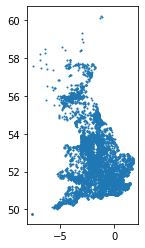

In [31]:
%%time

spatial_data_dir = '../data/spatial'

df_postcodes = pd.concat((pd.read_csv(f'{spatial_data_dir}/{f}', header=None) for f in os.listdir(spatial_data_dir) if '.csv' in f)).reset_index(drop=True)
df_postcodes = df_postcodes[[0, 2, 3]].rename(columns={0: 'postcode', 2: 'northing', 3: 'easting'})
gdf_postcodes = gpd.GeoDataFrame(df_postcodes[['postcode']], geometry=gpd.points_from_xy(df_postcodes['northing'], df_postcodes['easting']), crs='epsg:27700').to_crs('epsg:4326')

gdf_postcodes.sample(int(1e4)).plot(markersize=1)

In [42]:
gdf_postcodes['latitude'] = gdf_postcodes['geometry'].y
gdf_postcodes['longitude'] = gdf_postcodes['geometry'].x

In [43]:
gdf_postcodes.head()

,postcode,geometry,latitude,longitude
0,AB101AB,POINT (-2.09692 57.14961),57.149606,-2.096916
1,AB101AF,POINT (-2.09781 57.14871),57.148707,-2.097806
2,AB101AG,POINT (-2.09700 57.14907),57.149067,-2.096997
3,AB101AH,POINT (-2.09466 57.14808),57.148080,-2.094664
4,AB101AL,POINT (-2.09591 57.15007),57.150074,-2.095909


In [44]:
gdf_postcodes[['postcode', 'longitude', 'latitude']].to_csv('../data/postcodes.csv')

In [33]:
%%time

gdf_postcodes = gpd.read_file('../data/postcodes.shp')

Wall time: 1min 25s


In [ ]:
df_postcodes[['postcode', 'longitude', 'latitude']].to_csv('../data/postcodes.csv', index=F)

In [45]:
df_postcodes = pd.read_csv('../data/postcodes.csv')

df_postcodes

,Unnamed: 0,postcode,longitude,latitude
0,0,AB101AB,-2.096916,57.149606
1,1,AB101AF,-2.097806,57.148707
2,2,AB101AG,-2.096997,57.149067
3,3,AB101AH,-2.094664,57.148080
4,4,AB101AL,-2.095909,57.150074
...,...,...,...,...
1714208,1714208,ZE3 9JU,-1.307206,59.889544
1714209,1714209,ZE3 9JW,-1.305697,59.873651
1714210,1714210,ZE3 9JX,-1.307502,59.875286
1714211,1714211,ZE3 9JY,-1.313847,59.891572


In [4]:
# incident_active (if known)
# logged/start time
# estimated time of fix
# postcodes impacted
# description